In [1]:
import nibabel as nib
import numpy as np
import load_confounds

in_cii = '/scratch/dimuthu1/PPMI_project2/derivatives/fmriprep_20_2_1_test_syn_sdc/fmriprep/sub-3116/ses-Month12/func/sub-3116_ses-Month12_task-rest_run-1_space-fsLR_den-91k_bold.dtseries.nii'
cii = nib.load(in_cii)
timeseries = cii.get_fdata()

In [2]:
from load_confounds import Params36
file = "/scratch/dimuthu1/PPMI_project2/derivatives/fmriprep_20_2_1_test_syn_sdc/fmriprep/sub-3116/ses-Month12/func/sub-3116_ses-Month12_task-rest_run-1_space-fsLR_den-91k_bold.dtseries.nii"
confounds = Params36().load(file)

print(np.shape(confounds))

(210, 42)


In [3]:
from nilearn import signal
clean_ts = signal.clean(timeseries, confounds=confounds).T
print(np.shape(clean_ts))

(91282, 210)


In [4]:
clean_ts = clean_ts.T

atlas_L = nib.load('../L.atlasroi.32k_fs_LR.shape.gii')
atlas_L = atlas_L.darrays[0].data
atlas_R = nib.load('../R.atlasroi.32k_fs_LR.shape.gii')
atlas_R = atlas_R.darrays[0].data
atlas = np.hstack((atlas_L,atlas_R))

print(atlas)

#atlas = nib.load('../91282_Greyordinates.dscalar.nii').get_fdata()




schaefer_left = nib.load('../schaefer-1000.L.32k_fs_LR.label.gii').darrays[0].data
schaefer_right = nib.load('../schaefer-1000.R.32k_fs_LR.label.gii').darrays[0].data
schaefer_LR = np.hstack((schaefer_left,schaefer_right))
labels_LR_no_medialwall = schaefer_LR[atlas==1]

atlas = nib.load('../91282_Greyordinates.dscalar.nii').get_fdata()
new_1 = clean_ts[:,(atlas[0]==1)]

print(np.shape(new_1))



print(np.shape(labels_LR_no_medialwall))



[1. 1. 1. ... 1. 1. 1.]
(210, 59412)
(59412,)


In [5]:
from brainspace.utils.parcellation import reduce_by_labels
cortex_vals = reduce_by_labels(new_1, labels_LR_no_medialwall, axis=0, red_op='sum')

print(np.shape(new_1))
print(np.shape(cortex_vals))

mean_ts = np.zeros((len(new_1), 1000))
#print(len(clean_ts))

for i in range(0,1000):
    mean_ts[:,i] = np.mean(new_1[:,(labels_LR_no_medialwall==i+1)], axis =1)


print(np.shape(mean_ts))
mean_ts = np.nan_to_num(mean_ts)

(210, 59412)
(210, 999)
(210, 1000)


In [6]:
print(np.shape(atlas))
print(np.shape(clean_ts))

(1, 91282)
(210, 91282)


In [7]:

#fmri_data_ctx = fmri_fdata[:,0:len(schaefer_LR)]

#all = np.zeros((len(fmri_data_ctx), 1))

subctx_dict = {0: (12, 51, 'putamen'),
               1: (11, 50, 'caudate'),
               2: (26, 58, 'accumbens')}

put_L = clean_ts[:,(atlas[0]==12)]
#put_R = clean_ts[:,(atlas[0]==51)]
cau_L = clean_ts[:,(atlas[0]==11)]
#cau_R = clean_ts[:,(atlas[0]==50)]
acc_L = clean_ts[:,(atlas[0]==26)]
#acc_R = clean_ts[:,(atlas[0]==58)]

print(np.shape(put_L))
print(np.shape(acc_L))
#subctx_vals = np.concatenate((put_L, put_R, cau_L, cau_R, acc_L, acc_R),axis=1)
subctx_vals = np.concatenate((put_L, cau_L, acc_L),axis=1)

print(np.shape(subctx_vals))

(210, 1060)
(210, 135)
(210, 1923)


In [8]:
#combining cortex and sub cortex
print(np.unique(mean_ts))
#combined_ts = np.concatenate((cortex_vals,subctx_vals), axis=1)
combined_ts = np.concatenate((mean_ts,subctx_vals), axis=1)

print(np.shape(combined_ts))

[-3.57662848 -3.38615374 -3.2223603  ...  3.42310753  3.60917215
  3.66205846]
(210, 2923)


In [9]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([combined_ts])[0]

print(np.shape(correlation_matrix))

(2923, 2923)


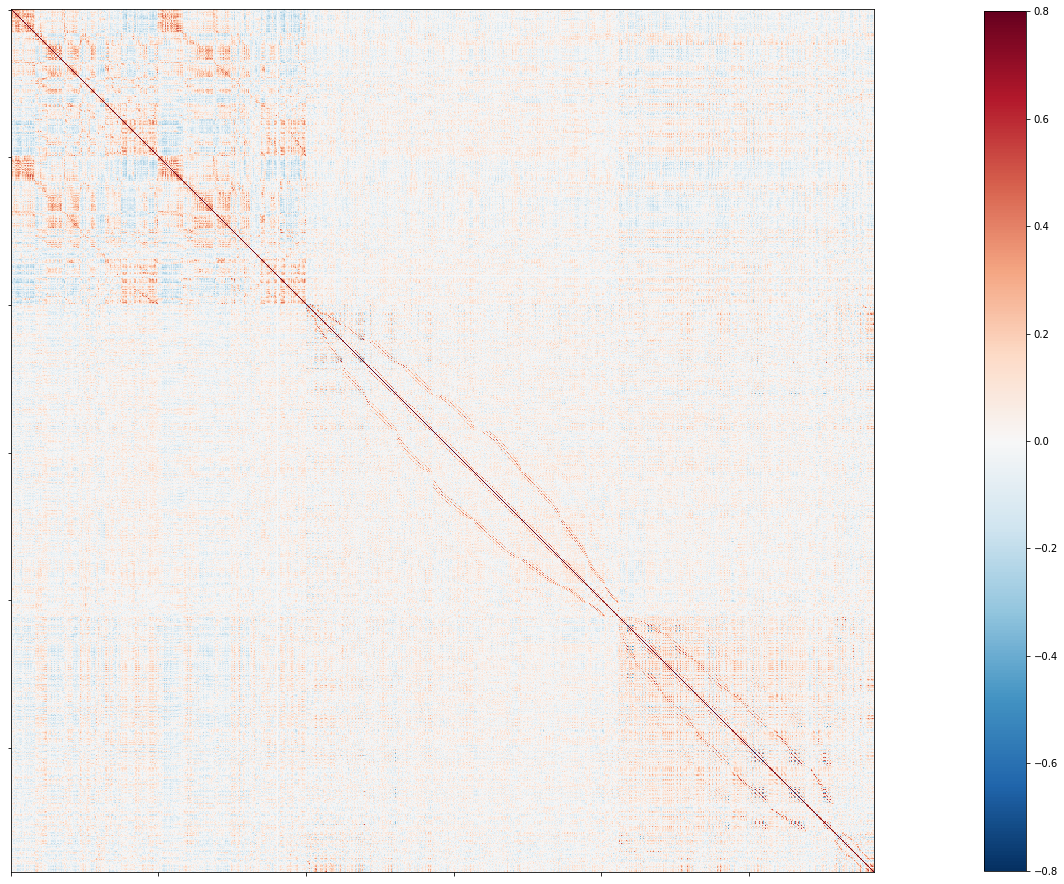

In [10]:
from nilearn import plotting

# Reduce matrix size, only for visualization purposes
#mat_mask = np.where(np.std(correlation_matrix, axis=1) > 0.2)[0]
#c = correlation_matrix[mat_mask][:, mat_mask]

# Create corresponding region names
#regions_list = ['%s_%s' % (h, r.decode()) for h in ['L', 'R'] for r in regions]
#masked_regions = [regions_list[i] for i in mat_mask]


corr_plot = plotting.plot_matrix(correlation_matrix, figure=(15, 15), vmax=0.8, vmin=-0.8)

In [11]:
sliced_matrix = correlation_matrix[:500,:500]
#slice = arr[0:2,0:2]

print(np.shape(sliced_matrix))


#sliced_matrix = (sliced_matrix+1)/2

print(np.unique(sliced_matrix))

(500, 500)
[-0.3496116  -0.3496116  -0.34718607 ...  0.56817837  0.57327313
  1.        ]


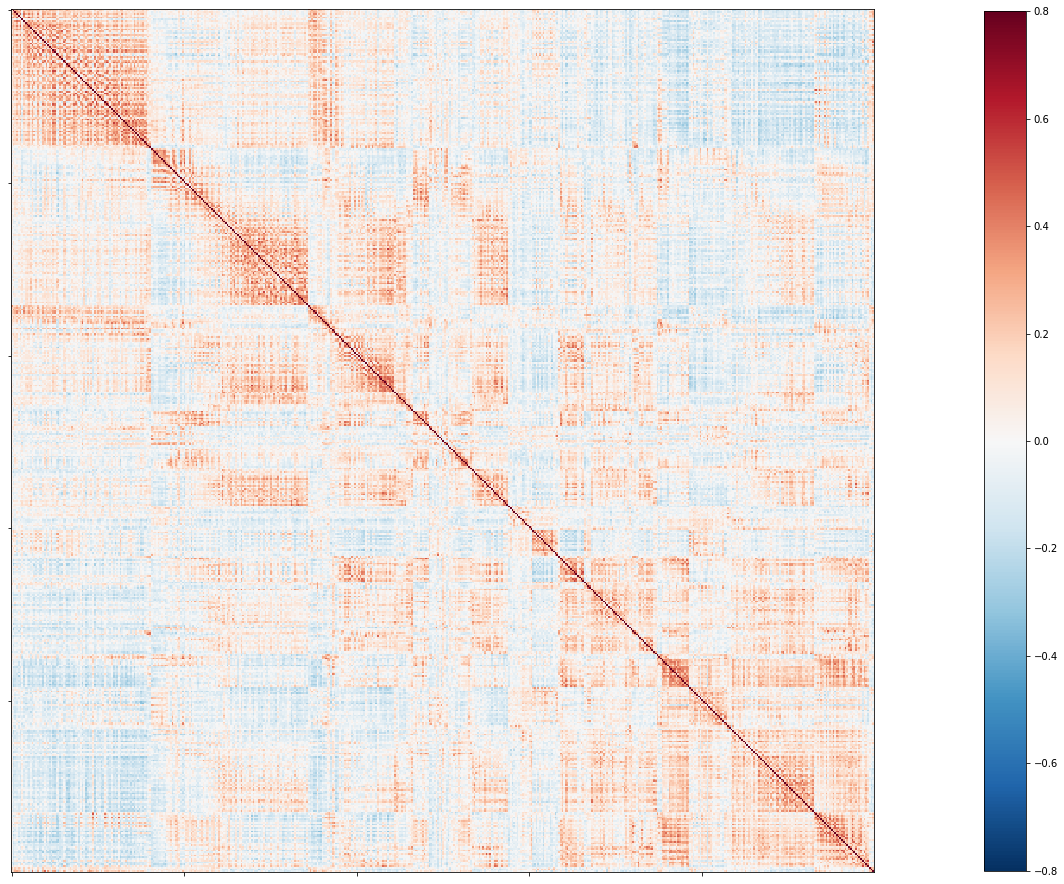

In [15]:
corr_plot = plotting.plot_matrix(sliced_matrix, figure=(15, 15), vmax=0.8, vmin=-0.8)

(500, 500)


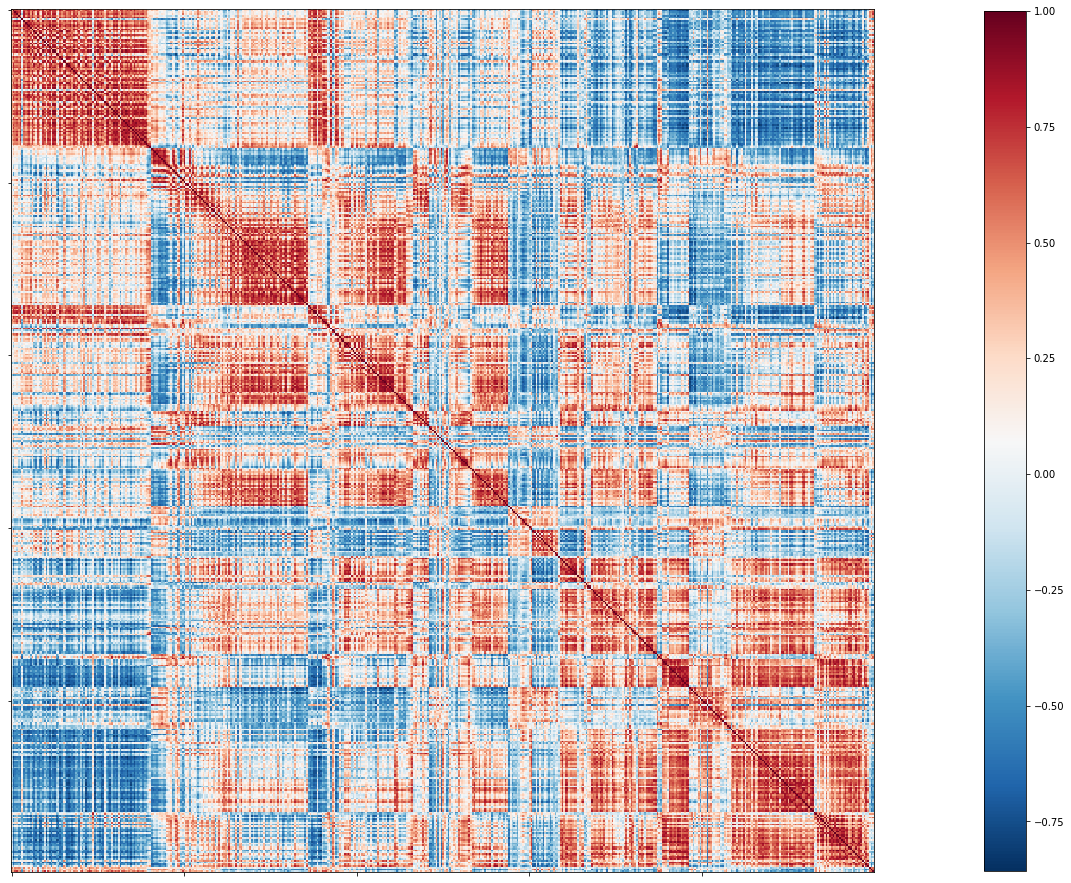

In [18]:
from brainspace.gradient import GradientMaps

from sklearn.metrics.pairwise import cosine_similarity
from mapalign.embed import DiffusionMapEmbedding

import pandas as pd

sim_matrix = cosine_similarity(sliced_matrix, sliced_matrix)
#sim_matrix = cosine_similarity(combined_ts.T, combined_ts.T)
#sim_matrix = sim_matrix[:500,500:]

print(np.shape(sim_matrix))

#corr_plot = plotting.plot_matrix(sim_matrix, figure=(15, 15))

gm = GradientMaps(n_components=3, random_state=0)
gm.fit(sim_matrix)

#gm = DiffusionMapEmbedding(alpha=0.5, diffusion_time=1, affinity='markov', n_components=5).fit_transform(sliced_matrix.copy())
    
#gradient_df = pd.DataFrame({'L_grad_1': gm[:,0],
#			 'L_grad_2': gm[:,1], 'L_grad_3': gm[:,2], 'L_grad_4': gm[:,3]})

corr_plot = plotting.plot_matrix(sim_matrix, figure=(15, 15))

In [14]:
grad_1 = gm.gradients_.T[0]
grad_2 = gm.gradients_.T[1]
grad_3 = gm.gradients_.T[2]

gradient_df = pd.DataFrame({'L_grad_1': grad_1, 'L_grad_2': grad_2, 'L_grad_3': grad_3})



AttributeError: 'numpy.ndarray' object has no attribute 'gradients_'

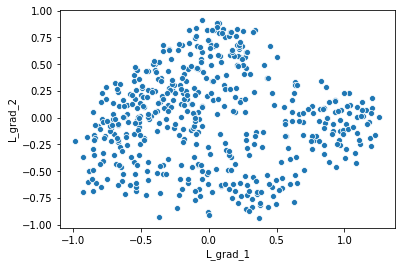

In [19]:

import seaborn as sns
import matplotlib.pyplot as plt


#dataset = pd.DataFrame({'grad_1': grad_1, 'grad_2': grad_2, 'grad_3': grad_3})

#print(dataset)

#sns.scatterplot(x="grad_1", y="grad_2",data = dataset)
sns.scatterplot(x="L_grad_1", y="L_grad_2",data = gradient_df)


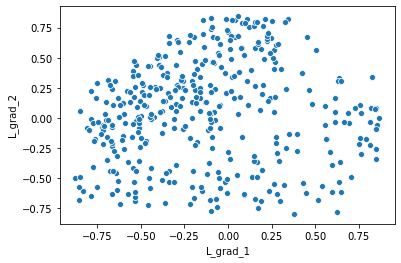

In [22]:
from scipy.stats import zscore

def remove_outliers(df):
	z_scores = zscore(df)

	abs_z_scores = np.abs(z_scores)
	filtered_entries = (abs_z_scores < 2).all(axis=1)
	new_df = df[filtered_entries]

	return new_df


gradient_df = remove_outliers(gradient_df)
sns.scatterplot(x="L_grad_1", y="L_grad_2",data = gradient_df)
